In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
from utils import *
import os
import re
import seaborn as sns
from itertools import product
import pickle 
from Bio.Seq import Seq
import scipy.stats as ss
import pyranges as pr
%matplotlib inline

In [2]:
for replicate in ["HJR244_1", "HJR244_2"]:
    
    # Create folder for saving plots
    plot_dir = "/home/yanhu/data/DddA/HJR244/plots/" + replicate
    if not os.path.exists(plot_dir):
        os.system("mkdir " + plot_dir)

    # Create a dictionary for reference regions
    ref_range_dict = {
        'HJR244': ('chr11', 5279265, 5282582)
    }
    
    # Initialize ddda_dataset
    ddda_data = ddda_dataset(
        ID = replicate, 
        region_dict = ref_range_dict, 
        genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
        fastq_file = "/home/yanhu/data/DddA/HJR244/fastqs/" + replicate + "/merged.fastq.gz", 
        working_dir = "/home/yanhu/data/DddA/HJR244/"
    )
    
    # Load DddA bias model
    bias_model_path = "/home/yanhu/data/DddA/HJR245/bias_dict.pkl"
    ddda_data.load_bias_model(bias_model_path)
    
    # Align reads
    gap_threshold = 500
    ddda_data.align_reads(
        start_gap_threshold = gap_threshold,
        end_gap_threshold = gap_threshold,
        ABE_edits = True
    )
    
    # Specify locus of interest
    locus = "HJR244"

    with open("/home/yanhu/data/DddA/HJR244/ddda_data_" + replicate + "_no_ABE_control.pkl", "wb") as f:
        pickle.dump(ddda_data, f)

Loading reference genome
Extracting sequences for each locus
Computing sequence bias


1312885it [05:58, 3666.02it/s]


1124263 reads aligned. 188622 reads unaligned
Loading reference genome
Extracting sequences for each locus
Computing sequence bias


2327778it [10:35, 3660.99it/s]


2039554 reads aligned. 288224 reads unaligned


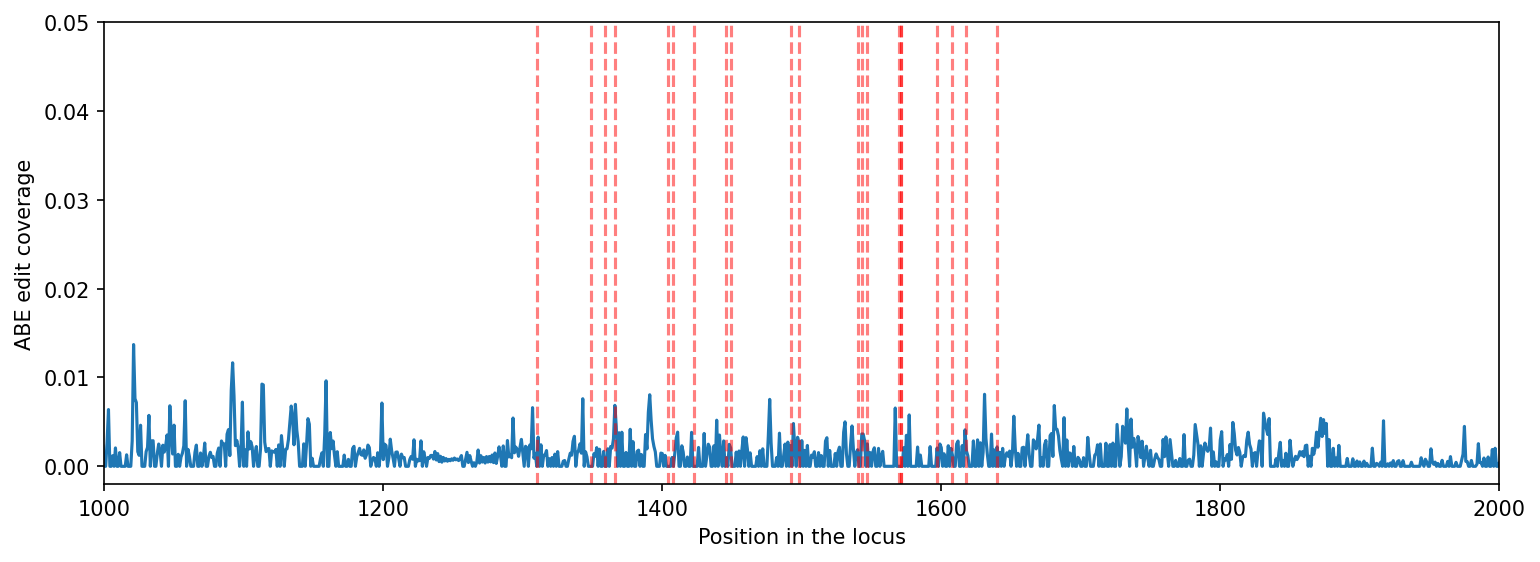

In [3]:
# Load sgRNA sequences
sgRNAs = pd.read_csv("/home/yanhu/data/DddA/HJR244/sgRNA.tsv", sep="\t", header=None)
sgRNAs.columns = ["ID", "sequence"]

# Get sequence of the target locus
ref_seq = ddda_data.ref_seq_dict[locus]

# Find sgRNA positions in the target locus
target_sites = []
for i, row in sgRNAs.iterrows():
    guide_seq_forward = row["sequence"].upper()
    guide_seq_reverse = str(Seq(guide_seq_forward).reverse_complement())
    forward_match = ref_seq.find(guide_seq_forward)
    reverse_match = ref_seq.find(guide_seq_reverse)
    if forward_match >= 0 and reverse_match == -1:
        targte_site = forward_match + 5 
    elif forward_match == -1 and reverse_match >= 0:
        targte_site = reverse_match + 15
    else:
        raise ValueError("No match or multiple matches for sgRNA found in the target locus")
    target_sites.append(targte_site)

# Sort sgRNA ABE edit sites by coordinate
target_sites = sorted(target_sites)

# Visualize ABE edit coverage and sgRNA positions
ABE_coverage = np.array(np.mean(ddda_data.ABE_edit_dict[locus], axis=0))[0]
plt.figure(dpi=150, figsize=(12, 4))
plt.plot(np.arange(len(ABE_coverage)), ABE_coverage)
for targte_site in target_sites:
    plt.axvline(x = targte_site, color="red", linestyle="dashed", alpha=0.5)
plt.ylabel("ABE edit coverage")
plt.xlabel("Position in the locus")
plt.xlim([1000,2000])
plt.ylim([-0.002,0.05])
plt.savefig(os.path.join(plot_dir, "ABE_edit_coverage.pdf"))

In [4]:
with open("/home/yanhu/data/DddA/HJR244/no_ABE_editing_rate.pkl", "wb") as f:
    pickle.dump(ABE_coverage, f)